In [1]:
# Import neccesary modules
# Set matplotlib to inline mode for the Jupyter notebook visualisations

%matplotlib inline

import rospy
from sensor_msgs.msg import LaserScan
from nav_msgs.srv import GetMap
from nav_msgs.msg import OccupancyGrid

import numpy as np
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
import math

global resolution
resolution = None

# Helper method for retrieving the map
def getMap() -> OccupancyGrid:
    """ Loads map from map service """
    # Create service proxy
    get_map = rospy.ServiceProxy('static_map', GetMap)
    # Call service
    recMap = get_map()
    recMap = recMap.map
    # the map resolution
    global resolution
    resolution = float(recMap.info.resolution)
    # Return
    return recMap

def splitMap(map):
    """ Iterates over the map cells and add each to a corresponding list
        according to whether it is a wall or free space
        Arguments:
        map: 2d list of integers, 
             each a percentage chance of empty or occupied space.
             Indices of each integer = coordinates
    """
    # the arrays to hold the free and wall cells in the map
    global wallPositions
    wallPositions = None
    global freePositions
    freePositions = None

    # info from the map variable
    mapData = np.array(map.data)
    mapInfo = map.info
    # convert the data to a 2d array (coordinates with occupancy certaincy)
    map = np.split(mapData, map.info.width)
    
    # iteration counters serving as indices for the arrays
    x:int = 0 
    y:int = 0

    # nested loop to go through each cell
    # certainty of occupance is rated 0 - 100
    for row in map:
        for cell in row:
            x_coord = x*mapInfo.resolution + mapInfo.origin.position.x + mapInfo.resolution/2
            y_coord = y*mapInfo.resolution + mapInfo.origin.position.y + mapInfo.resolution/2
            pos = np.array([[x_coord, y_coord]])
            if cell == 0:
                # add to empty space list
                if freePositions is not None:
                    freePositions = np.vstack((freePositions, pos))
                else:
                    freePositions = pos
            else:
                # add to wall list
                if wallPositions is not None:
                    wallPositions = np.vstack((wallPositions, pos))
                else:
                    wallPositions = pos
            y += 1
        y = 0
        x += 1

def laserScanSubCallback(msg):
    """ Loads the laserscan from message """
    # check if the map has been received
    if resolution is None:
        return
    # arrange the angles
    angles = np.arange(msg.angle_min, msg.angle_max, msg.angle_increment)

    global scan
    scan = None
    for distance, angle in zip(msg.ranges, angles):
        x = math.sin(angle)*(distance + resolution/2)
        y = math.cos(angle)*(distance + resolution/2)
        pos = np.array([[x, y]])
        if scan is not None:
            scan = np.vstack((scan, pos))
        else:
            scan = pos

laserScanSub = rospy.Subscriber("/scan", LaserScan, laserScanSubCallback)

# Initiate ROS node
rospy.init_node('mazeEscape')
recMap = getMap()

# split the map into free and wall cells
splitMap(recMap)

dump = rospy.wait_for_message("/scan", LaserScan, 9999999)

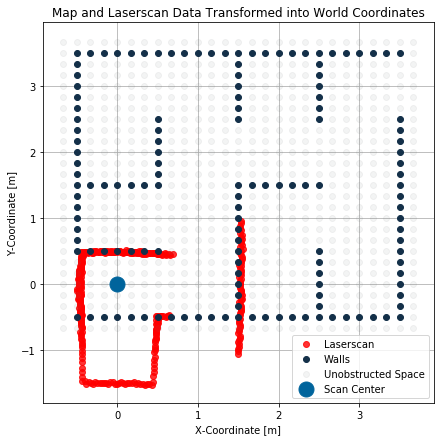

In [2]:
# Store colours matching UAS TW colour scheme as dict 
colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

## Visualise transformed maze and scans
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot data as points (=scatterplot) and label accordingly. The colours are to look nice with UAS TW colours
ax.scatter(scan[:,1], scan[:,0], c="r", alpha=0.8, label="Laserscan")
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(freePositions[:,1], freePositions[:,0], c=colourScheme["twgrey"], alpha=0.08, s=6**2, label="Unobstructed Space")
ax.scatter([0], [0], c=colourScheme["twblue"], s=15**2, label="Scan Center")

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Map and Laserscan Data Transformed into World Coordinates")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()